In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression



In [2]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

all_stocks = prices_df.columns[1:100]
training_stocks = all_stocks[1:10]
other_stocks = all_stocks[5:]

# Calculate returns
returns_df = prices_df[all_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for easier calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()




In [3]:
forecast_horizon = 21 # trading days
test_start_date = pd.to_datetime('2015-01-01')
test_end_date = pd.to_datetime('2021-05-15')

messages = {"test_start": [], "test_end": []}

# Check if test_start_date exists in the DataFrame, if not, take the next date that exists
if test_start_date not in returns_df['Date'].values:
    test_start_date = returns_df['Date'][returns_df['Date'] > test_start_date].bfill().iloc[0]
    messages["test_start"] = messages["test_start"] or ['Start date not found, using closest next date instead.']

# Check if test_end_date exists in the DataFrame, if not, take the previous date that exists
if test_end_date not in returns_df['Date'].values:
    test_end_date = returns_df['Date'][returns_df['Date'] < test_end_date].ffill().iloc[-1]
    messages["test_end"] = messages["test_end"] or ['End date not found, using closest date instead.']

test_start = returns_df.loc[returns_df['Date'] == test_start_date].index[0]
test_end = returns_df.loc[returns_df['Date'] == test_end_date].index[0]

del test_start_date, test_end_date, messages

Helper methods

In [4]:
#functions
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] \
                                 if volatility[stock] > 0 else 0 for stock in all_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(all_stocks))



methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"].extend([volatility[stock]])
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)
    
def reset_portfolio_metrics(method):
    for stock in all_stocks:
        methods[method][stock + " predicted volatility"] = []
    methods[method]["returns"] = []

def standardize_returns(returns_matrix):
    mean_returns = np.mean(returns_matrix)
    std_returns = np.std(returns_matrix)
    standardized_returns = np.where(std_returns!=0, (returns_matrix - mean_returns) / std_returns, 0)
    return standardized_returns.reshape(-1, 1)

def get_linear_regression_model(X, y, fit_intercept=True, positive=False):
    model = LinearRegression(fit_intercept=fit_intercept, positive=positive)
    model.fit(X, y)

    return model

Benchmark models(oracle, equal weight)

In [5]:
method = "Oracle" + "+" + str(forecast_horizon)
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() \
                  for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)

method = "EqualWeight"
reset_portfolio_metrics(method)

for i in range(test_start, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    gather_portfolio_metrics(method, i, volatility)



In [6]:
#covariation matrix for all stocks
volatility = {stock: returns_df[stock][test_start: test_end].std() for stock in all_stocks}

values = np.array(list(volatility.values()))

correlation_matrix = returns_df.iloc[:, 1:].corr()

covariation_matrix = correlation_matrix * np.outer(values, values)

del volatility

In [7]:
#get data for vix index
import yfinance as yf

vix = yf.Ticker("^VIX")

vix_data = vix.history(start="2000-01-03", end="2021-07-15")

vix_data = vix_data[["Close"]]



Linear regression models

In [8]:
global window, train_start, train_end
window = 21 # Set window to 21 days from now on for computational efficiency
train_start = (test_start - window) % forecast_horizon + window + 126 
train_end = test_start # Training end is the start of the test period

method = "EqualWeight train"
reset_portfolio_metrics(method)

eq_betas = []

for i in range(0, test_end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in all_stocks}

    #gather_portfolio_metrics(method, i, volatility)
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)

    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    eq_betas.extend(returns)
    

A, B = [], []
def get_linear_regression_model(A, B, fit_intercept=True):
    # Fit a linear regression model with non-negative coefficients and no intercept
    model = LinearRegression(positive=True, fit_intercept=fit_intercept)
    model.fit(np.array(A), np.array(B))
    #A.clear()
    #B.clear()

    return model

In [9]:
print(len(methods["EqualWeight train"]["returns"]))

0


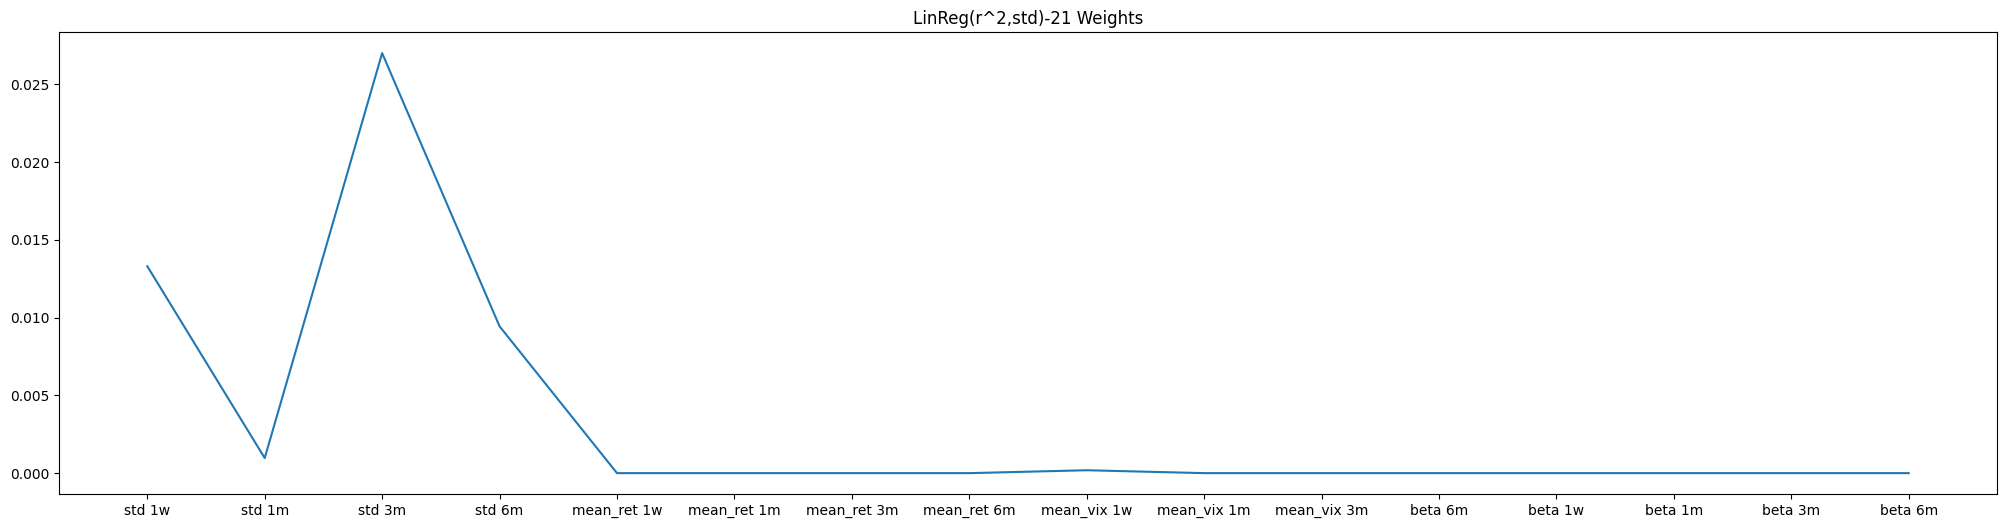

[0.23213748829936054]
[0.23213748829936054, 0.667898211070127]
[0.23213748829936054, 0.667898211070127, 1.111961055401908]
[0.23213748829936054, 0.667898211070127, 1.111961055401908, 1.2934626377474796]
[0.3010991496884092]
[0.3010991496884092, 0.5819412202369775]
[0.3010991496884092, 0.5819412202369775, 1.5071676487511845]
[0.3010991496884092, 0.5819412202369775, 1.5071676487511845, 1.349462805306608]
[2.502142569325566]
[2.502142569325566, 0.5255888362677723]
[2.502142569325566, 0.5255888362677723, 0.8718431245591116]
[2.502142569325566, 0.5255888362677723, 0.8718431245591116, 0.8956246983881273]
[0.3384926046826118]
[0.3384926046826118, 0.7767166721718267]
[0.3384926046826118, 0.7767166721718267, 1.5700560599388667]
[0.3384926046826118, 0.7767166721718267, 1.5700560599388667, 1.2221139062819029]
[1.3980271362270766]
[1.3980271362270766, 1.4518382255444724]
[1.3980271362270766, 1.4518382255444724, 1.207573659339203]
[1.3980271362270766, 1.4518382255444724, 1.207573659339203, 1.268763

In [10]:
method = "LinReg(r^2,std)" + "-" + str(window)
reset_portfolio_metrics(method)

betas_train, oracle_betas_train = {}, {}

for stock in training_stocks:
    betas_train[stock] = []
    oracle_betas_train[stock] = []

x_label = ['std 1w', 'std 1m', 'std 3m', 'std 6m', 'mean_ret 1w', 'mean_ret 1m', 'mean_ret 3m', 'mean_ret 6m', 'mean_vix 1w', 'mean_vix 1m', 'mean_vix 3m', 'beta 6m','beta 1w', 'beta 1m', 'beta 3m', 'beta 6m'] 
windows = [5, 21, 63, 126]

A, B = [], []
# Iterate over each window of returns
g = 0
for stock in training_stocks:
    g += 1
    for i in range(train_start, train_end, forecast_horizon):
        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:

            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std()* (252 ** 0.5))
            mean_ret.append((1 + returns_df[stock][i - window:i].mean()) ** 252)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            #print(methods["EqualWeight"]["returns"][i - window:i])

            standardized_market_index_returns = standardize_returns(eq_betas[i - window:i])
        
            X = standardized_returns
            y = standardized_market_index_returns
           
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        # Sada dodaj tu listu kao jedan element u A
        A.append(features)
        B.append(returns_df[stock][i:i + forecast_horizon].std())


methods[method]["model"] = get_linear_regression_model(A, B, False) 
# Intercept might make variance negative

plt.figure(figsize=(25, 6))
plt.plot(methods[method]["model"].coef_)
plt.title(method + " Weights")
plt.xticks(range(len(x_label)), x_label)
plt.show()

volatility = {}

for i in range(test_start, test_end, forecast_horizon):
    for stock in all_stocks:

        std = []
        mean_ret = []
        mean_vix = []
        betas = []

        for window in windows:
            #dobij sve feature koje ubacujemo u model
            std.append(returns_df[stock][i - window:i].std() * (252 ** 0.5))
            mean_ret.append((1 + returns_df[stock][i - window:i].mean()) ** 252)
            print(mean_ret)
            mean_vix.append(float(vix_data[i - window: i].mean().iloc[0]))

            standardized_returns = standardize_returns(returns_df[stock][i - window:i])
            standardized_market_index_returns = standardize_returns(eq_betas[i - window:i])
        

            X = standardized_returns
            y = standardized_market_index_returns
            
            model = get_linear_regression_model(X, y, fit_intercept=False)
            beta = model.coef_[0][0]
            if abs(beta) >= 1:
                raise Exception(f"Beta value {beta} is not in the range [-1, 1]")
            betas.append(beta)

        # Grupiraj kvadrirane povrate i prosječni VIX u jednu listu prije dodavanja u A
        features = std + mean_ret + mean_vix + betas
        
        features = np.array(features).reshape(1, -1)
        #  Trying to predict the volatility of the next forecast_horizon days
        volatility[stock] = methods[method]["model"].predict(features)
            
    
    gather_portfolio_metrics(method, i, volatility)

Portfolio performance

In [11]:
#potroflio metrics
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Volatility": [np.std(portfolio["returns"]) * 252**0.5 \
                   for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 \
               for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) \
               / (np.std(portfolio["returns"]) * 252**0.5) \
                for portfolio in methods.values()]
}


display(pd.DataFrame(portfolios_df))

c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\filip\miniconda3\envs\everything\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Portfolio,Volatility,Return,Sharpe
0,Oracle+21,0.172646,0.198366,1.148971
1,EqualWeight,0.187890,0.207032,1.101881
2,EqualWeight train,NaN,NaN,NaN
3,"LinReg(r^2,std)-21",0.180179,0.194129,1.077426


ValueError: x and y must have same first dimension, but have shapes (1627,) and (0,)

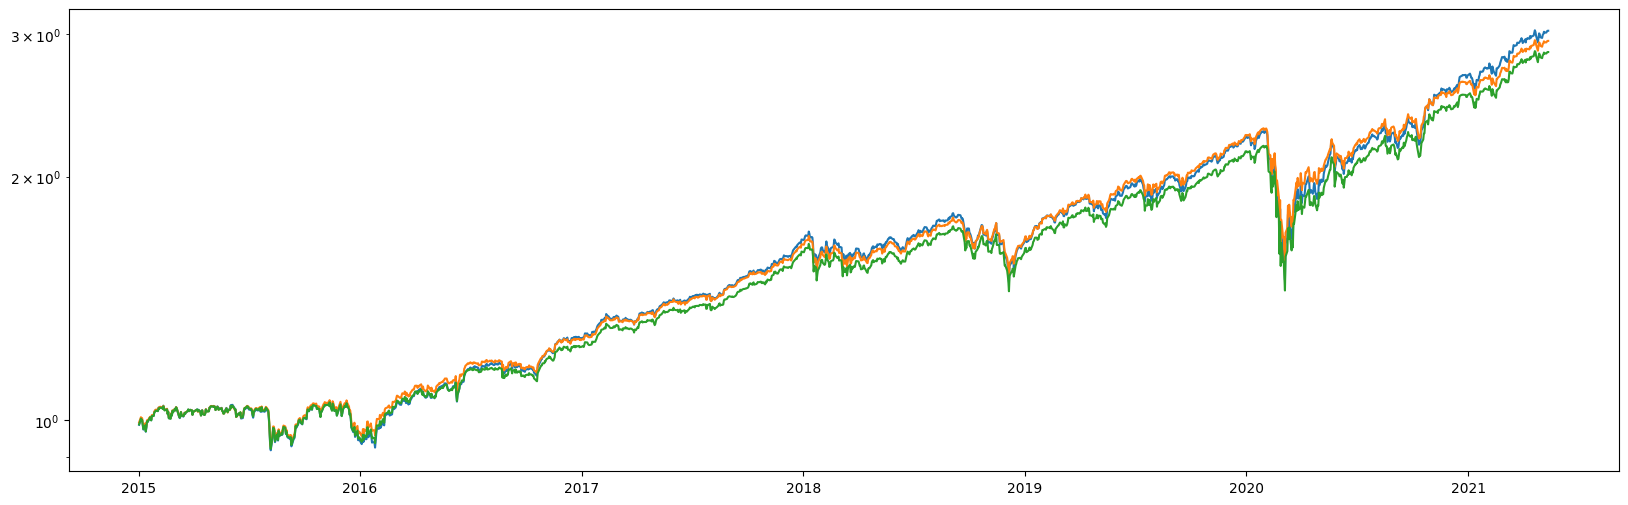

In [12]:
# Iterate over each portfolio in methods
for portfolio in methods.values():
    # Initialize the value list with a starting value of 1
    portfolio["value"] = [1]

    # Calculate the cumulative value of the portfolio
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret + 1) * portfolio["value"][-1])

# Get the dates for the test period
dates = returns_df.iloc[test_start:test_end, 0]

# Sort the methods by the final value of the portfolio, in descending order
sorted_methods = sorted(\
    methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

# Plot the performance of all portfolios
plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"][12:], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

In [ ]:
#maknut 1 za mean ret, dignit sve postotke za * 100
# napravit mse i to za model
# random forrest
# mse, 
#feature importance za rf